In [37]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.features as fs
#import socceraction.atomic.labels as lab

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"epl-spadl-statsbomb.h5")

In [5]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [6]:
with pd.HDFStore(spadl_h5) as spadlstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

380it [00:17, 22.24it/s]


,game_id,period_id,action_id,time_seconds,timestamp,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name
0,14562.0,1.0,0,1.0,00:00:01.344,58.0,9923.0,52.058824,34.430380,-10.588235,-0.000000,0,0,pass
1,14562.0,1.0,1,1.5,00:00:02.117,58.0,9917.0,41.470588,34.430380,-0.000000,-0.000000,23,0,receival
2,14562.0,1.0,2,2.0,00:00:02.117,58.0,9917.0,41.470588,34.430380,-0.000000,-0.000000,21,0,dribble
3,14562.0,1.0,3,2.0,00:00:02.969,58.0,9917.0,41.470588,34.430380,-15.882353,-14.632911,0,0,pass
4,14562.0,1.0,4,3.0,00:00:04.338,58.0,9924.0,25.588235,19.797468,-0.000000,-0.000000,23,0,receival


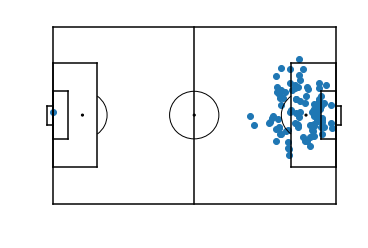

In [8]:
import matplotsoccer as mps
import matplotlib.pyplot as plt

a = actions[actions.type_name == "shot"][:100]
ax = mps.field(show=False)
ax.scatter(a.x,a.y)
plt.show()

In [165]:
%%time
import sklearn.cluster as clus
import sklearn.mixture as mix
a = actions[actions.type_name == "receival"][:10000].copy()
#c = clus.KMeans(20).fit(a[["x","y"]])

nbc = 50

gmm = mix.GaussianMixture(nbc).fit(a[["x","y"]])

CPU times: user 3.84 s, sys: 3.41 s, total: 7.25 s
Wall time: 1.04 s


Text(0.5, 0, 'n_components')

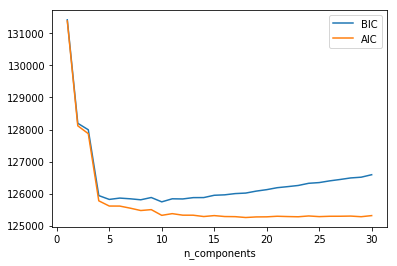

In [136]:
n_components = np.arange(1, 31)
models = [mix.GaussianMixture(n).fit(a[["x","y"]])
          for n in n_components]

plt.plot(n_components, [m.bic(a[["x","y"]]) for m in models], label='BIC')
plt.plot(n_components, [m.aic(a[["x","y"]]) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

['#984ea3', '#a65628', '#f781bf', '#4daf4a', '#ffff33', '#ff7f00', '#377eb8', '#e41a1c', '#377eb8', '#ff7f00', '#a65628', '#999999', '#984ea3', '#e41a1c', '#f781bf', '#f781bf', '#ff7f00', '#ff7f00', '#377eb8', '#f781bf', '#984ea3', '#e41a1c', '#ff7f00', '#999999', '#f781bf', '#984ea3', '#a65628', '#999999', '#377eb8', '#4daf4a', '#999999', '#377eb8', '#999999', '#4daf4a', '#e41a1c', '#984ea3', '#4daf4a', '#377eb8', '#984ea3', '#a65628', '#4daf4a', '#ffff33', '#e41a1c', '#ffff33', '#a65628', '#ffff33', '#e41a1c', '#ff7f00', '#ffff33', '#4daf4a']


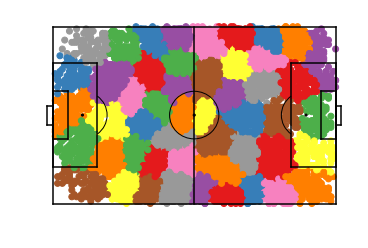

In [166]:
colors = ["#e41a1c",
"#377eb8",
"#4daf4a",
"#984ea3",
"#ff7f00",
"#ffff33",
"#a65628",
"#f781bf",
"#999999",
         ]
clustercolors = color_clusters(gmm.means_,colors)
print(clustercolors)
labels = gmm.predict(a[["x","y"]])

ax = mps.field(show=False)
ax.scatter(a.x,a.y,color=[clustercolors[l] for l in labels])
plt.show()

In [167]:
#ax = mps.field(show=False)
#x = [cc[0] for cc in c.cluster_centers_]
#y = [cc[1] for cc in c.cluster_centers_]
x = [cc[0] for cc in gmm.means_]
y = [cc[1] for cc in gmm.means_]

from scipy.spatial import Delaunay
import networkx as nx

def color_clusters(clusters,colors):
    tri = Delaunay(clusters)
    edges = set()
    for s in tri.simplices:
        [a,b,c] = s
        es = set([frozenset([a,b]),frozenset([b,c]),frozenset([c,a])])
        edges = edges | es
    G = nx.Graph()
    for e in edges:
        [i,j] = list(e)
        G.add_edge(i, j)
    
    if len(G.nodes) > 0:
        r_ = max([G.degree(node) for node in G.nodes])
    else:
        r_ = 0
    if r_ > len(colors)-1:
        colorassign = nx.algorithms.coloring.greedy_color(G)
    else:
        colorassign = nx.algorithms.coloring.equitable_color(G,len(colors))
    colorvector = [0] * len(clusters)
    for k,v in colorassign.items():
        colorvector[k] = int(v)
    return [colors[i] for i in colorvector]

color_clusters(gmm.means_,colors)

['#984ea3',
 '#a65628',
 '#f781bf',
 '#4daf4a',
 '#ffff33',
 '#ff7f00',
 '#377eb8',
 '#e41a1c',
 '#377eb8',
 '#ff7f00',
 '#a65628',
 '#999999',
 '#984ea3',
 '#e41a1c',
 '#f781bf',
 '#f781bf',
 '#ff7f00',
 '#ff7f00',
 '#377eb8',
 '#f781bf',
 '#984ea3',
 '#e41a1c',
 '#ff7f00',
 '#999999',
 '#f781bf',
 '#984ea3',
 '#a65628',
 '#999999',
 '#377eb8',
 '#4daf4a',
 '#999999',
 '#377eb8',
 '#999999',
 '#4daf4a',
 '#e41a1c',
 '#984ea3',
 '#4daf4a',
 '#377eb8',
 '#984ea3',
 '#a65628',
 '#4daf4a',
 '#ffff33',
 '#e41a1c',
 '#ffff33',
 '#a65628',
 '#ffff33',
 '#e41a1c',
 '#ff7f00',
 '#ffff33',
 '#4daf4a']

In [168]:
import numpy

nbp = len(set(a.player_id))
vectors = np.zeros((nbp,nbc))

player_ids = []
for i,(player_id,df) in tqdm.tqdm(enumerate(a.groupby(["player_id"]))):
    probs = gmm.predict_proba(df[["x","y"]])
    playervector = probs.sum(axis=0)
    player_ids.append(player_id)
    vectors[i,:] = playervector
#vectors

200it [00:00, 476.94it/s]


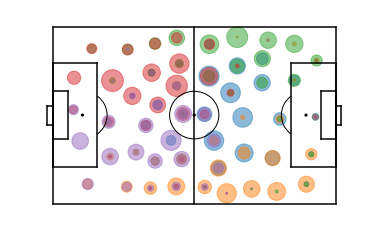

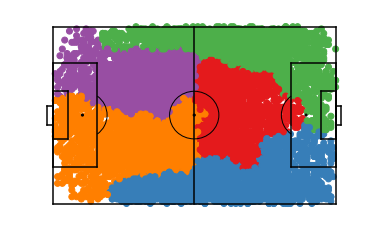

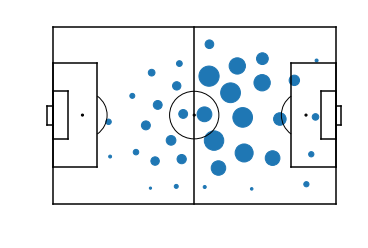

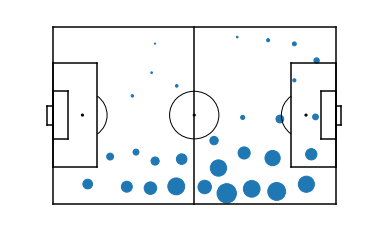

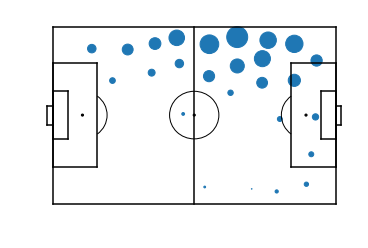

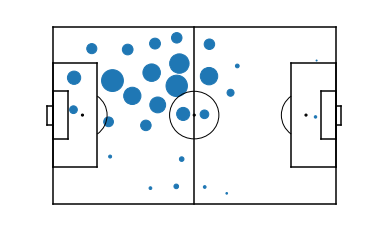

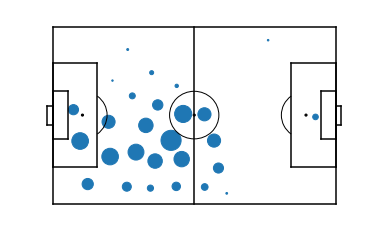

In [169]:
from sklearn.decomposition import NMF
model = NMF(5).fit(vectors)
model.components_

#print(model.components_ )

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

ax = mps.field(show=False)
for component in model.components_:
    c_idx = component > 0.1
    ax.scatter(x,y,s=100*component,alpha=0.5)
    #plt.show()
plt.show()    

def predict_cluster(points,gmm,nmf):
    gaussprobs = gmm.predict_proba(points)
    clusterscores = nmf.transform(gaussprobs)
    return np.argmax(clusterscores,axis=1)

points = a[["x","y"]].values
clusterlabels = predict_cluster(points,gmm,model)
ax = mps.field(show=False)
x,y = zip(*points)
ax.scatter(x,y,color=[colors[l] for l in clusterlabels])
plt.show()

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

for component in model.components_:
    c_idx = component > 0.1
    ax = mps.field(show=False)
    ax.scatter(x,y,s=100*component,alpha=1)
    plt.show()